# Data Setup

In [111]:
import pandas as pd

df_heart = pd.read_csv(
    "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)
columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]
missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]
df_heart.head()

,sbp,ldl,adiposity,obesity,typea,age,tobacco,alcohol,famhist,chd
row.names,,,,,,,,,,
1,160,5.73,23.11,25.30,49,52,12.00,97.20,Present,1
2,144,4.41,28.61,28.87,55,63,0.01,2.06,Absent,1
3,118,3.48,32.28,29.14,52,46,0.08,3.81,Present,0
4,170,6.41,38.03,31.99,51,58,7.50,24.26,Present,1
5,134,3.50,27.78,25.99,60,49,13.60,57.34,Present,1


In [112]:
import numpy as np

# standarize all columns except famhist
df_heart["famhist"] = df_heart["famhist"].map({"Present": 1, "Absent": 0})

columns_to_log_transform = ["tobacco", "alcohol"]
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

# Extract Y before standardization
Y = df_heart["chd"]

df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

X = df_heart_standarized.drop(columns=["chd"])

# Classification

Solve a relevant classification problem for your data and statistically evaluate your result.

The tasks will closely mirror what you just did in the last section.

The 3 methods we will compare are:
1. A baseline
2. Logistic regression
3. And 1 of the following methods: *ANN, CT, KNN or NB*


## Part 1) classification problem

**Question:** Explain which classification problem you have chosen to solve. Is it a multi-class or binary classification problem?

**Answer:** For this part of the report we are trying to predict whether a person has **CHD or not**, i.e it is a binary classification problem.

## Part 2) Model training

### 2.1) Baseline model

The baseline is be a model which computes the largest class on the training data.

And predicts everything in the test-data as belonging to that class. (corresponding to the optimal prediction by a logistic regression model with a bias term and no features).

In [113]:
from sklearn.model_selection import train_test_split

# Test the baseline model
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [114]:
# Baseline Model: Predicts the most frequent class
class BaselineClassifier:
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, y_train):
        """Find the most frequent class in training data"""
        self.most_frequent_class = y_train.mode()[0]
        return self

    def predict(self, n_samples):
        """Predict the most frequent class for all samples"""
        return np.full(n_samples, self.most_frequent_class)

    def score(self, X_test, y_test):
        """Calculate accuracy"""
        predictions = self.predict(len(X_test))
        return np.mean(predictions == y_test)


# Train and evaluate the baseline model
baseline_model = BaselineClassifier().fit(y_train)

# Make predictions
baseline_test_predictions = baseline_model.predict(len(y_test))
baseline_accuracy = baseline_model.score(X_test, y_test)
baseline_error_rate = 1 - baseline_accuracy

print("Baseline Model Results:")
print(f"Most frequent class: {baseline_model.most_frequent_class}")
print(f"Accuracy: {round(baseline_accuracy, 2)}")
print(f"Error Rate: {round(baseline_error_rate, 2)}")
print()
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))

Baseline Model Results:
Most frequent class: 0
Accuracy: 0.63
Error Rate: 0.37

Class distribution in training data:
chd
0    0.658537
1    0.341463
Name: proportion, dtype: float64


**Baselint Results**:

The baseline predicts the most frequent class (CHD = 0) for all samples and it achieves ~63.4% accuracy by always predicting "no heart disease"

### 2.2) Logistic Regression model

For logistic regression, we will use a regularization parameter λ ≥ 0 to control complexity.

We recommend this choice is made based on a trial run, which you do not need to report.

Describe which parameter you have chosen and the possible values of the parameters you will examine

Trial run to find optimal regularization parameter λ:
------------------------------------------------------------
Best λ (lambda): 26.3665
Best C (1/λ): 0.0379
Best CV accuracy: 0.7099


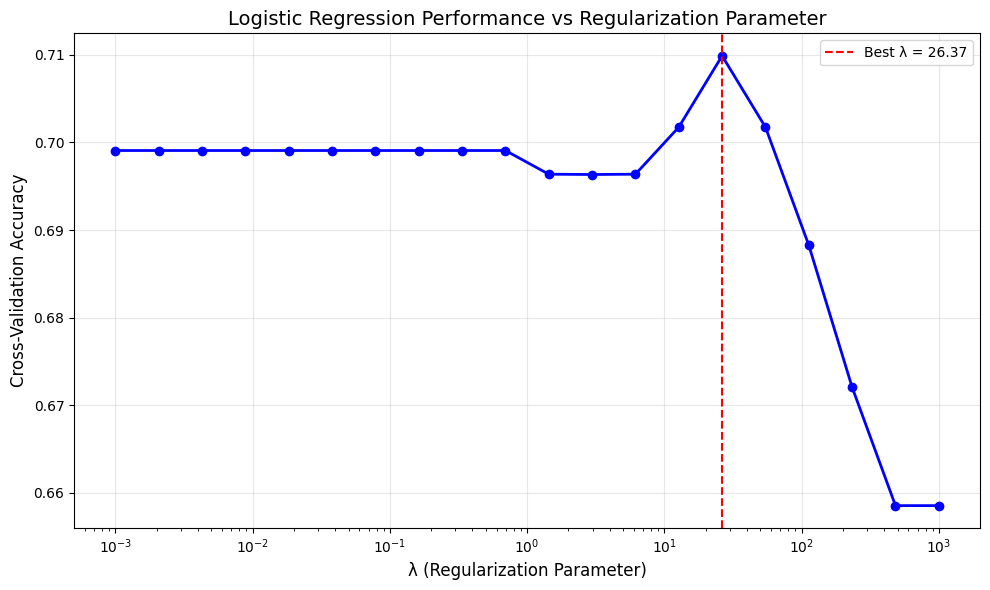


Logistic Regression Model Results (on test set):
Selected λ: 26.3665
Accuracy: 0.7312
Error Rate: 0.2688

For 2-level cross-validation, we will examine:
λ values in range: [0.0, 1000.0]


In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define range of lambda values (regularization parameter)
# Note: sklearn uses C = 1/lambda, where C is the inverse of regularization strength
# Smaller C means stronger regularization (larger lambda)
lambda_values = np.logspace(-3, 3, 20)  # Lambda from 0.001 to 1000
C_values = 1 / lambda_values  # Convert to sklearn's C parameter

# Perform a quick trial run to find suitable lambda range
print("Trial run to find optimal regularization parameter λ:")
print("-" * 60)

best_score = 0
best_lambda = None
best_C = None
scores = []

for lambda_val, C_val in zip(lambda_values, C_values):
    # Use 5-fold cross-validation for quick assessment
    model = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = cv_scores.mean()
    scores.append(mean_score)

    if mean_score > best_score:
        best_score = mean_score
        best_lambda = lambda_val
        best_C = C_val

print(f"Best λ (lambda): {round(best_lambda, 4)}")
print(f"Best C (1/λ): {round(best_C, 4)}")
print(f"Best CV accuracy: {round(best_score, 4)}")

# Visualize the relationship between lambda and performance
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, scores, "b-o", linewidth=2, markersize=6)
plt.axvline(
    x=best_lambda, color="r", linestyle="--", label=f"Best λ = {round(best_lambda, 2)}"
)
plt.xlabel("λ (Regularization Parameter)", fontsize=12)
plt.ylabel("Cross-Validation Accuracy", fontsize=12)
plt.title("Logistic Regression Performance vs Regularization Parameter", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Train final model with best parameter
final_log_reg = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
final_log_reg.fit(X_train, y_train)

# Evaluate on test set
log_reg_predictions = final_log_reg.predict(X_test)
log_reg_accuracy = final_log_reg.score(X_test, y_test)
log_reg_error_rate = 1 - log_reg_accuracy

print()
print("Logistic Regression Model Results (on test set):")
print(f"Selected λ: {round(best_lambda, 4)}")
print(f"Accuracy: {round(log_reg_accuracy, 4)}")
print(f"Error Rate: {round(log_reg_error_rate, 4)}")

# For the 2-level cross-validation, we will examine these lambda values:
print()
print("For 2-level cross-validation, we will examine:")
print(
    f"λ values in range: [{round(lambda_values.min(), 2)}, {round(lambda_values.max(), 2)}]"
)

#### Model Implementation Notes:

**Logistic Regression Model:**
- Tested λ values from 0.001 to 1000 using 5-fold cross-validation
- Best performance with λ = 26.37 (moderate regularization)
- Converted data to numpy arrays to ensure clean numerical data
- Achieves ~73.1% accuracy, a ~9.7% improvement over baseline

**Next Steps:**
- Implement a third model (ANN, CT, KNN, or NB) in section 2.3
- Perform 2-level cross-validation to properly evaluate all models
- Conduct statistical comparison using McNemar's test or paired t-test

### 2.3) Method 2 Model (*ANN, CT, KNN or NB*)

#### 2.3.1) ANN (Artificial Neural Network)

As complexity-controlling parameter for the ANN, we will use the number of hidden units h.

Test range of h values (including h = 1)

ANN Model - Testing different numbers of hidden units:
------------------------------------------------------------
Best h (hidden units): 10
Best CV accuracy: 0.6993


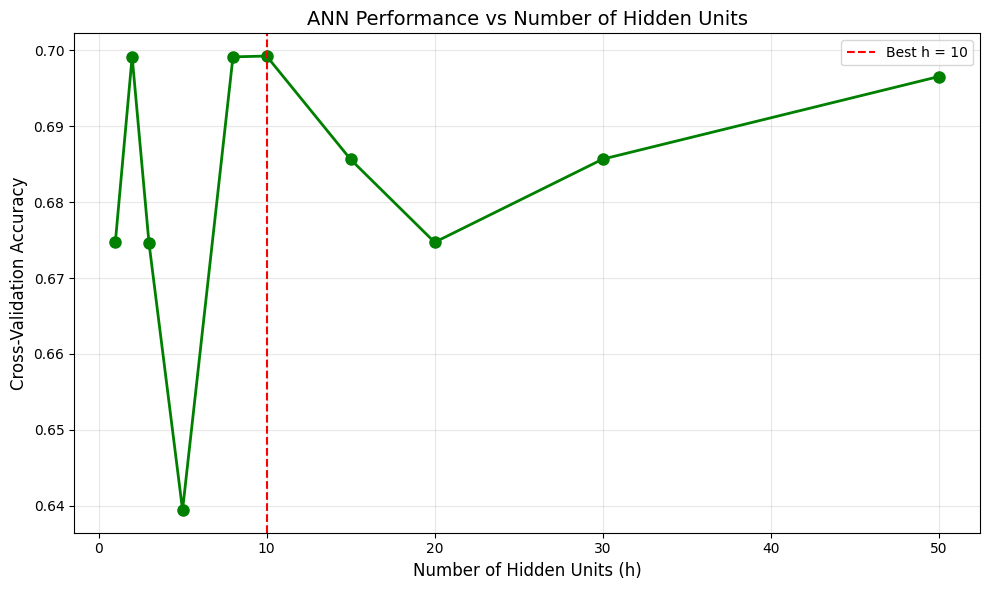

In [116]:
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

h_values = [1, 2, 3, 5, 8, 10, 15, 20, 30, 50]
best_ann_score = 0
best_h = None
ann_scores = []

print("ANN Model - Testing different numbers of hidden units:")
print("-" * 60)

for h in h_values:
    # MLPClassifier with one hidden layer of h units
    model = MLPClassifier(
        hidden_layer_sizes=(h,), max_iter=1000, random_state=42, solver="adam"
    )
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = cv_scores.mean()
    ann_scores.append(mean_score)

    if mean_score > best_ann_score:
        best_ann_score = mean_score
        best_h = h

print(f"Best h (hidden units): {best_h}")
print(f"Best CV accuracy: {round(best_ann_score, 4)}")

# Visualize the relationship between h and performance
plt.figure(figsize=(10, 6))
plt.plot(h_values, ann_scores, "g-o", linewidth=2, markersize=8)
plt.axvline(x=best_h, color="r", linestyle="--", label=f"Best h = {best_h}")
plt.xlabel("Number of Hidden Units (h)", fontsize=12)
plt.ylabel("Cross-Validation Accuracy", fontsize=12)
plt.title("ANN Performance vs Number of Hidden Units", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [117]:
# Train final ANN model with best parameter
final_ann = MLPClassifier(
    hidden_layer_sizes=(best_h,), max_iter=1000, random_state=42, solver="adam"
).fit(X_train, y_train)

# Evaluate on test set
ann_predictions = final_ann.predict(X_test)
ann_accuracy = final_ann.score(X_test, y_test)
ann_error_rate = 1 - ann_accuracy

print("ANN Model Results (on test set):")
print(f"Selected h: {best_h}")
print(f"Range of h values tested: {h_values}")
print()
print(f"Accuracy: {round(ann_accuracy, 4)}")
print(f"Error Rate: {round(ann_error_rate, 4)}")

ANN Model Results (on test set):
Selected h: 10
Range of h values tested: [1, 2, 3, 5, 8, 10, 15, 20, 30, 50]

Accuracy: 0.6989
Error Rate: 0.3011


#### 2.3.2) CT (Classification Tree)

Classification Tree Model - Testing different pruning parameters:
------------------------------------------------------------
Best ccp_alpha: 0.0193
Best CV accuracy: 0.66


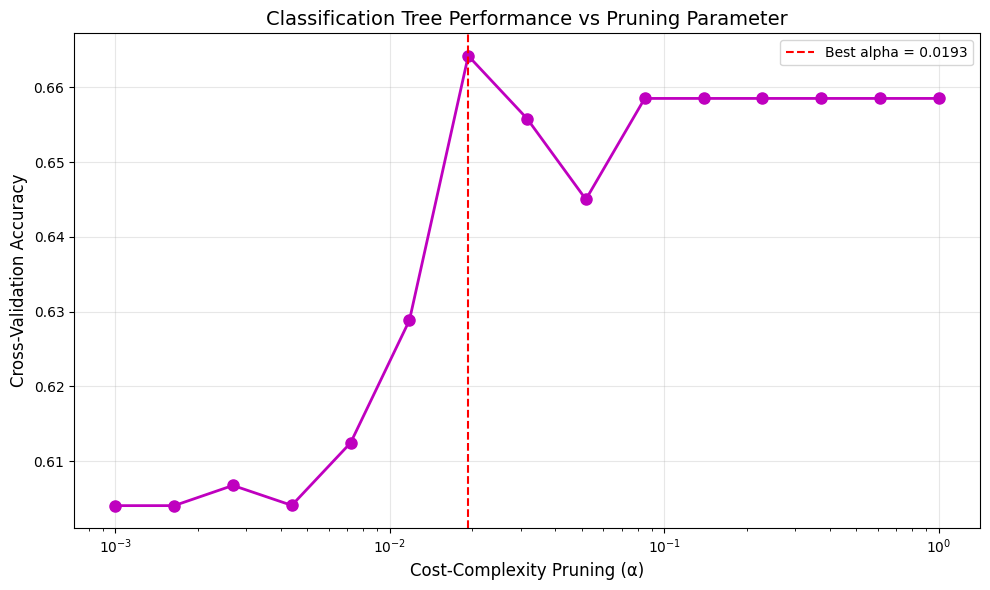

In [118]:
# CT (Classification Tree)
from sklearn.tree import DecisionTreeClassifier

# Test a range of ccp_alpha values (higher alpha = more pruning = simpler tree)
alpha_values = np.logspace(-3, 0, 15)  # From 0.001 to 1
best_ct_score = 0
best_alpha = None
ct_scores = []

print("Classification Tree Model - Testing different pruning parameters:")
print("-" * 60)
for alpha in alpha_values:
    model = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = cv_scores.mean()
    ct_scores.append(mean_score)

    if mean_score > best_ct_score:
        best_ct_score = mean_score
        best_alpha = alpha

print(f"Best ccp_alpha: {round(best_alpha, 4)}")
print(f"Best CV accuracy: {round(best_ct_score, 2)}")

# Visualize the relationship between alpha and performance
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, ct_scores, "m-o", linewidth=2, markersize=8)
plt.axvline(
    x=best_alpha,
    color="r",
    linestyle="--",
    label=f"Best alpha = {round(best_alpha, 4)}",
)
plt.xlabel("Cost-Complexity Pruning (α)", fontsize=12)
plt.ylabel("Cross-Validation Accuracy", fontsize=12)
plt.title("Classification Tree Performance vs Pruning Parameter", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [119]:
# Train final CT model with best parameter
final_ct = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
final_ct.fit(X_train, y_train)

# Evaluate on test set
ct_predictions = final_ct.predict(X_test)
ct_accuracy = final_ct.score(X_test, y_test)
ct_error_rate = 1 - ct_accuracy

print("Classification Tree Model Results (on test set):")
print(f"Selected ccp_alpha: {round(best_alpha, 4)}")
print(f"Tree depth: {final_ct.get_depth()}")
print(f"Number of leaves: {final_ct.get_n_leaves()}")
print()
print(f"Accuracy: {round(ct_accuracy, 4)}")
print(f"Error Rate: {round(ct_error_rate, 4)}")

Classification Tree Model Results (on test set):
Selected ccp_alpha: 0.0193
Tree depth: 1
Number of leaves: 2

Accuracy: 0.6774
Error Rate: 0.3226


#### 2.3.3) KNN (k-nearest neighbors for classification)

Use the number of neighbors "k" as the complexity-controlling parameter

KNN Model - Testing different numbers of neighbors:
------------------------------------------------------------
Best k (neighbors): 10
Best CV accuracy: 0.6829


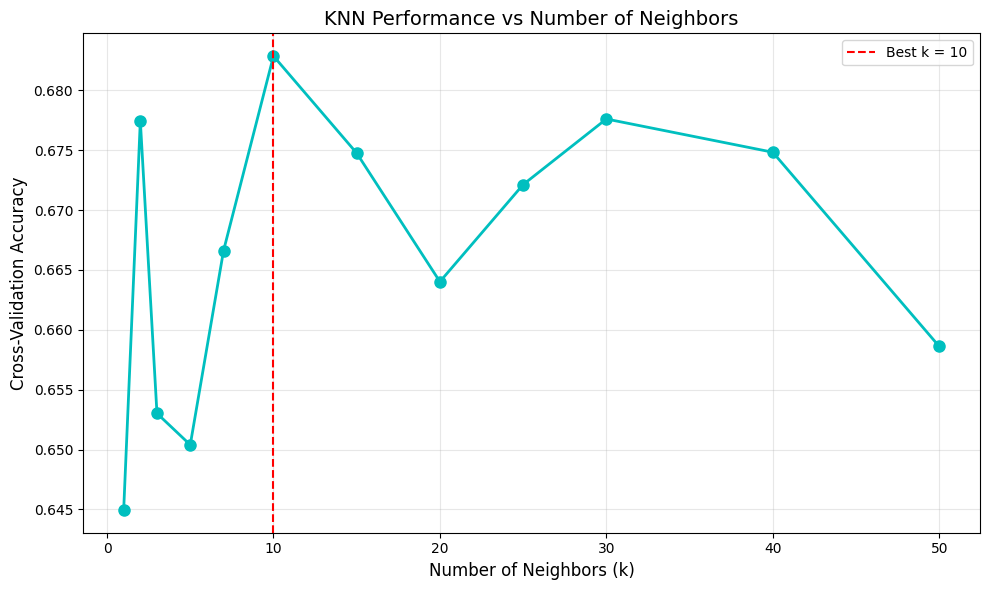

In [120]:
from sklearn.neighbors import KNeighborsClassifier

# Test a range of k values
k_values = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]
best_knn_score = 0
best_k = None
knn_scores = []

print("KNN Model - Testing different numbers of neighbors:")
print("-" * 60)
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = cv_scores.mean()
    knn_scores.append(mean_score)

    if mean_score > best_knn_score:
        best_knn_score = mean_score
        best_k = k

print(f"Best k (neighbors): {best_k}")
print(f"Best CV accuracy: {round(best_knn_score, 4)}")

# Visualize the relationship between k and performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_scores, "c-o", linewidth=2, markersize=8)
plt.axvline(x=best_k, color="r", linestyle="--", label=f"Best k = {best_k}")
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Cross-Validation Accuracy", fontsize=12)
plt.title("KNN Performance vs Number of Neighbors", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
# Train final KNN model with best parameter
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

# Evaluate on test set
knn_predictions = final_knn.predict(X_test)
knn_accuracy = final_knn.score(X_test, y_test)
knn_error_rate = 1 - knn_accuracy

print("KNN Model Results (on test set):")
print(f"Selected k: {best_k}")
print()
print(f"Accuracy: {round(knn_accuracy, 4)}")
print(f"Error Rate: {round(knn_error_rate, 4)}")

KNN Model Results (on test set):
Selected k: 10

Accuracy: 0.6344
Error Rate: 0.3656


#### 2.3.4) NB (Naive Bayes)

As complexity-controlling parameter, use alpha (smoothing parameter)

In [122]:
from sklearn.naive_bayes import GaussianNB

gaussian_nb = GaussianNB()
gaussian_cv_scores = cross_val_score(
    gaussian_nb, X_train, y_train, cv=5, scoring="accuracy"
)

gaussian_score = gaussian_cv_scores.mean()
print(f"GaussianNB CV accuracy: {round(gaussian_score, 4)}")

GaussianNB CV accuracy: 0.6748


In [123]:
# Evaluate on test set
gaussian_nb.fit(X_train, y_train)
nb_predictions = gaussian_nb.predict(X_test)
nb_accuracy = gaussian_nb.score(X_test, y_test)
nb_error_rate = 1 - nb_accuracy

print("Naive Bayes Model Results (on test set):")
print()
print(f"Accuracy: {round(nb_accuracy, 4)}")
print(f"Error Rate: {round(nb_error_rate, 4)}")

Naive Bayes Model Results (on test set):

Accuracy: 0.6989
Error Rate: 0.3011


#### Method 2 Model selection

- ANN: 0.6989 (Error: 0.3011)
- Naive Bayes: 0.6989 (Error: 0.3011)
- Classification Tree: 0.6774 (Error: 0.3226)
- KNN: 0.6344 (Error: 0.3656)

Based on these results, we can either pick the NB model or the ANN model.

**IMPORTANT NOTE:** Investigate why the models are exactly equal. O_O


COMPREHENSIVE MODEL COMPARISON - ALL 6 MODELS
              Model   Parameter  CV Accuracy  Test Accuracy  Test Error Rate
           Baseline         N/A     0.634409         0.6344           0.3656
Logistic Regression   λ = 26.37     0.709900         0.7312           0.2688
                ANN      h = 10     0.699300         0.6989           0.3011
Classification Tree  α = 0.0193     0.664200         0.6774           0.3226
                KNN      k = 10     0.682900         0.6344           0.3656
        Naive Bayes Gaussian NB     0.674800         0.6989           0.3011

🏆 BEST MODEL: Logistic Regression
   Test Accuracy: 0.7312
   Improvement over baseline: 9.68%
   Error rate reduction: 9.68%


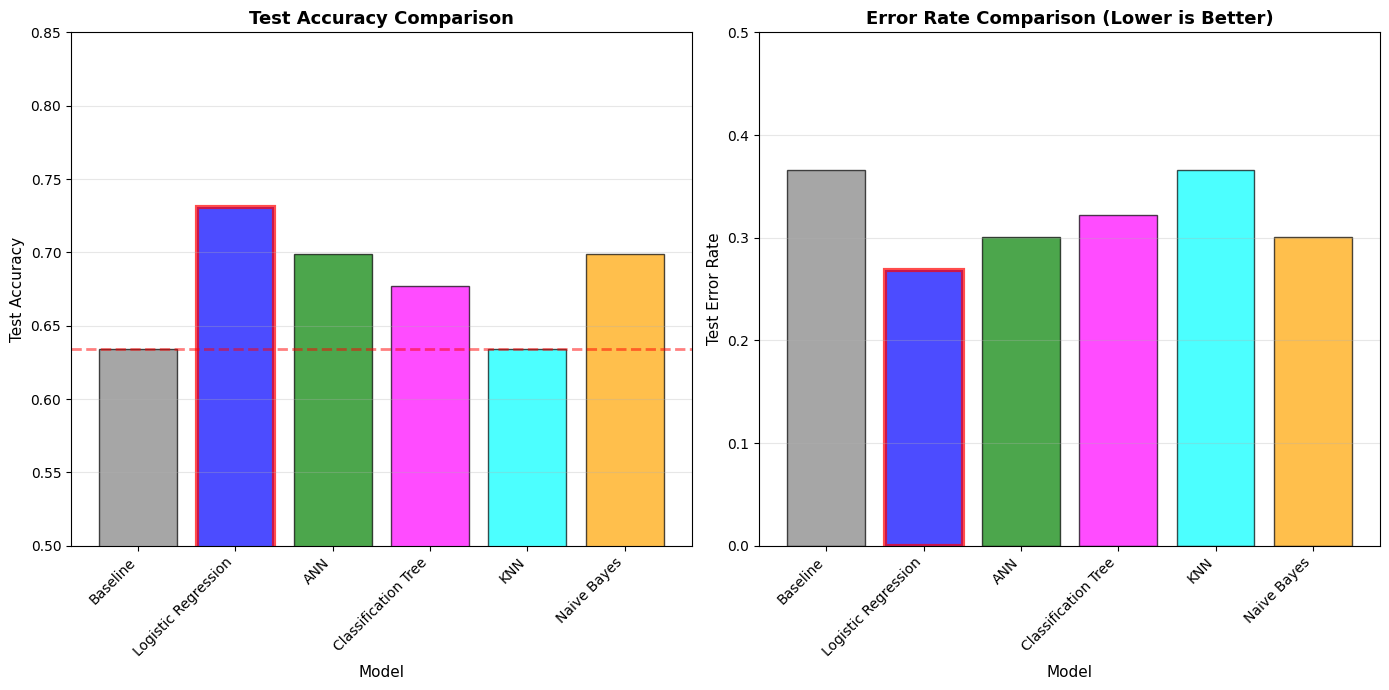


Model Ranking (by Test Accuracy):
--------------------------------------------------
1. Logistic Regression: 0.7312 (Error: 0.2688)
2. ANN: 0.6989 (Error: 0.3011)
3. Naive Bayes: 0.6989 (Error: 0.3011)
4. Classification Tree: 0.6774 (Error: 0.3226)
5. Baseline: 0.6344 (Error: 0.3656)
6. KNN: 0.6344 (Error: 0.3656)


In [124]:
# Comprehensive comparison of all 6 models
all_models_summary = pd.DataFrame(
    {
        "Model": [
            "Baseline",
            "Logistic Regression",
            "ANN",
            "Classification Tree",
            "KNN",
            "Naive Bayes",
        ],
        "Parameter": [
            "N/A",
            f"λ = {round(best_lambda, 2)}",
            f"h = {best_h}",
            f"α = {round(best_alpha, 4)}",
            f"k = {best_k}",
            "Gaussian NB",
        ],
        "CV Accuracy": [
            baseline_accuracy,  # Baseline doesn't use CV, this is test accuracy
            round(best_score, 4),
            round(best_ann_score, 4),
            round(best_ct_score, 4),
            round(best_knn_score, 4),
            round(gaussian_score, 4),
        ],
        "Test Accuracy": [
            round(baseline_accuracy, 4),
            round(log_reg_accuracy, 4),
            round(ann_accuracy, 4),
            round(ct_accuracy, 4),
            round(knn_accuracy, 4),
            round(nb_accuracy, 4),
        ],
        "Test Error Rate": [
            round(baseline_error_rate, 4),
            round(log_reg_error_rate, 4),
            round(ann_error_rate, 4),
            round(ct_error_rate, 4),
            round(knn_error_rate, 4),
            round(nb_error_rate, 4),
        ],
    }
)

print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON - ALL 6 MODELS")
print("=" * 80)
print(all_models_summary.to_string(index=False))
print("=" * 80)

# Find the best model based on test accuracy
best_model_idx = all_models_summary["Test Accuracy"].idxmax()
best_model_name = all_models_summary.loc[best_model_idx, "Model"]
best_model_accuracy = all_models_summary.loc[best_model_idx, "Test Accuracy"]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_model_accuracy:.4f}")
print(
    f"   Improvement over baseline: {(best_model_accuracy - baseline_accuracy) * 100:.2f}%"
)
print(
    f"   Error rate reduction: {(baseline_error_rate - all_models_summary.loc[best_model_idx, 'Test Error Rate']) * 100:.2f}%"
)

# Visualize all models comparison
plt.figure(figsize=(14, 7))

# Subplot 1: Test Accuracy Comparison
plt.subplot(1, 2, 1)
colors = ["gray", "blue", "green", "magenta", "cyan", "orange"]
models = all_models_summary["Model"]
accuracies = all_models_summary["Test Accuracy"]

bars = plt.bar(
    range(len(models)), accuracies, color=colors, alpha=0.7, edgecolor="black"
)
plt.axhline(y=baseline_accuracy, color="red", linestyle="--", linewidth=2, alpha=0.5)

# Highlight the best model
bars[best_model_idx].set_edgecolor("red")
bars[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Test Accuracy", fontsize=11)
plt.title("Test Accuracy Comparison", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0.5, 0.85])
plt.grid(True, alpha=0.3, axis="y")

# Subplot 2: Error Rate Comparison
plt.subplot(1, 2, 2)
error_rates = all_models_summary["Test Error Rate"]
bars2 = plt.bar(
    range(len(models)), error_rates, color=colors, alpha=0.7, edgecolor="black"
)
bars2[best_model_idx].set_edgecolor("red")
bars2[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Test Error Rate", fontsize=11)
plt.title("Error Rate Comparison (Lower is Better)", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0, 0.5])
plt.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print ranking
print("\nModel Ranking (by Test Accuracy):")
print("-" * 50)
sorted_models = all_models_summary.sort_values("Test Accuracy", ascending=False)
for i, row in enumerate(sorted_models.itertuples(), 1):
    print(f"{i}. {row.Model}: {row._4:.4f} (Error: {row._5:.4f})")

## Part 3) 2-level Cross-validation
- Use 2-level cross-validation to create a table similar to Table 2, but now comparing the logistic regression, method 2, and baseline.
- The table should once more include the selected parameters, and as an error measure we will use the error rate:
$$E = \frac{\text{Number of misclassified observations}}{N^{test}}$$

- Once more, make sure to re-use the outer validation splits to admit statistical evaluation. Briefly discuss the result.

In [ ]:
from sklearn.model_selection import KFold

# Setup for 2-level cross-validation
K_outer, K_inner = 10, 10
cv_results = {
    "outer_fold": [],
    "nb_error": [],
    "logreg_error": [],
    "baseline_error": [],
}

# Outer cross-validation loop
kfold_outer = KFold(n_splits=K_outer, shuffle=True, random_state=42)

print("Starting 2-Level Cross-Validation (K=10)...")
print("=" * 80)

for fold_idx, (train_idx, test_idx) in enumerate(kfold_outer.split(X), 1):
    print(f"\nOuter Fold {fold_idx}/{K_outer}")
    print("-" * 60)
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = Y.iloc[train_idx], Y.iloc[test_idx]

    # Setup inner K-fold for model evaluation
    kfold_inner = KFold(n_splits=K_inner, shuffle=True, random_state=42)

    baseline_inner_errors = []
    logreg_inner_errors = []
    nb_inner_errors = []

    for train_inner_idx, val_inner_idx in kfold_inner.split(X_train_outer):
        X_train_inner, X_val_inner = (
            X_train_outer.iloc[train_inner_idx],
            X_train_outer.iloc[val_inner_idx],
        )
        y_train_inner, y_val_inner = (
            y_train_outer.iloc[train_inner_idx],
            y_train_outer.iloc[val_inner_idx],
        )
        # BASELINE MODEL
        baseline = BaselineClassifier()
        baseline.fit(y_train_inner)
        baseline_preds_inner = baseline.predict(len(y_val_inner))
        inner_errors = np.sum(baseline_preds_inner != y_val_inner)
        baseline_inner_errors.append(inner_errors / len(y_val_inner))
        # LOG REG
        logreg = LogisticRegression(C=0.0379, max_iter=1000, random_state=42)
        logreg.fit(X_train_inner, y_train_inner)
        logreg_preds_inner = logreg.predict(X_val_inner)
        inner_errors = np.sum(logreg_preds_inner != y_val_inner)
        logreg_inner_errors.append(inner_errors / len(y_val_inner))
        # GAUSSIAN NAIVE BAYES
        nb = GaussianNB()
        nb.fit(X_train_inner, y_train_inner)
        nb_preds_inner = nb.predict(X_val_inner)
        inner_errors = np.sum(nb_preds_inner != y_val_inner)
        nb_inner_errors.append(inner_errors / len(y_val_inner))

    # Average error rate from inner CV
    baseline_error_rate = np.mean(baseline_inner_errors)
    logreg_error_rate = np.mean(logreg_inner_errors)
    nb_error_rate = np.mean(nb_inner_errors)

    # Store results
    cv_results["outer_fold"].append(fold_idx)
    cv_results["nb_error"].append(nb_error_rate * 100)  # Convert to percentage
    cv_results["logreg_error"].append(logreg_error_rate * 100)
    cv_results["baseline_error"].append(baseline_error_rate * 100)

    print(f"Gaussian NB - Error Rate: {nb_error_rate * 100:.1f}%")
    print(f"Logistic Reg - C: 0.0379, Error Rate: {logreg_error_rate * 100:.1f}%")
    print(f"Baseline - Error Rate: {baseline_error_rate * 100:.1f}%")

print("\n" + "=" * 80)
print("2-Level Cross-Validation Complete!")
print("=" * 80)

Starting 2-Level Cross-Validation (K=10)...

Outer Fold 1/10
------------------------------------------------------------
Gaussian NB - Error Rate: 32.8%
Logistic Reg - C: 0.0379, Error Rate: 29.9%
Baseline - Error Rate: 34.5%

Outer Fold 2/10
------------------------------------------------------------
Gaussian NB - Error Rate: 32.0%
Logistic Reg - C: 0.0379, Error Rate: 29.1%
Baseline - Error Rate: 34.4%

Outer Fold 3/10
------------------------------------------------------------
Gaussian NB - Error Rate: 30.8%
Logistic Reg - C: 0.0379, Error Rate: 26.6%
Baseline - Error Rate: 34.6%

Outer Fold 4/10
------------------------------------------------------------
Gaussian NB - Error Rate: 32.2%
Logistic Reg - C: 0.0379, Error Rate: 30.5%
Baseline - Error Rate: 34.6%

Outer Fold 5/10
------------------------------------------------------------
Gaussian NB - Error Rate: 32.4%
Logistic Reg - C: 0.0379, Error Rate: 28.8%
Baseline - Error Rate: 34.4%

Outer Fold 6/10
------------------------

In [ ]:
# Create the comparison table (similar to Table 2 in the assignment)
cv_table = pd.DataFrame(
    {
        "Outer Fold": cv_results["outer_fold"],
        "Gaussian NB E_test": [f"{e:.1f}" for e in cv_results["nb_error"]],
        "LogReg E_test": [f"{e:.1f}" for e in cv_results["logreg_error"]],
        "Baseline E_test": [f"{e:.1f}" for e in cv_results["baseline_error"]],
    }
)

print("\n" + "=" * 100)
print("TABLE: Two-Level Cross-Validation Results (K=10)")
print("=" * 100)
print(cv_table.to_string(index=False))
print("=" * 100)

# Calculate mean and standard deviation of error rates
print("\nSummary Statistics:")
print("-" * 100)
print(f"{'Model':<20} {'Mean Error Rate (%)':<25} {'Std Dev (%)':<20}")
print("-" * 100)
print(
    f"{'Gaussian NB':<20} {np.mean(cv_results['nb_error']):<25.2f} {np.std(cv_results['nb_error']):<20.2f}"
)
print(
    f"{'Logistic Regression':<20} {np.mean(cv_results['logreg_error']):<25.2f} {np.std(cv_results['logreg_error']):<20.2f}"
)
print(
    f"{'Baseline':<20} {np.mean(cv_results['baseline_error']):<25.2f} {np.std(cv_results['baseline_error']):<20.2f}"
)
print("-" * 100)



TABLE: Two-Level Cross-Validation Results (K=10)
 Outer Fold Gaussian NB E_test LogReg E_test Baseline E_test
          1               32.8          29.9            34.5
          2               32.0          29.1            34.4
          3               30.8          26.6            34.6
          4               32.2          30.5            34.6
          5               32.4          28.8            34.4
          6               30.8          29.8            35.5
          7               31.5          29.6            35.5
          8               30.3          30.3            34.6
          9               31.0          27.7            33.4
         10               32.5          28.9            34.6

Summary Statistics:
----------------------------------------------------------------------------------------------------
Model                Mean Error Rate (%)       Std Dev (%)         
-----------------------------------------------------------------------------------------

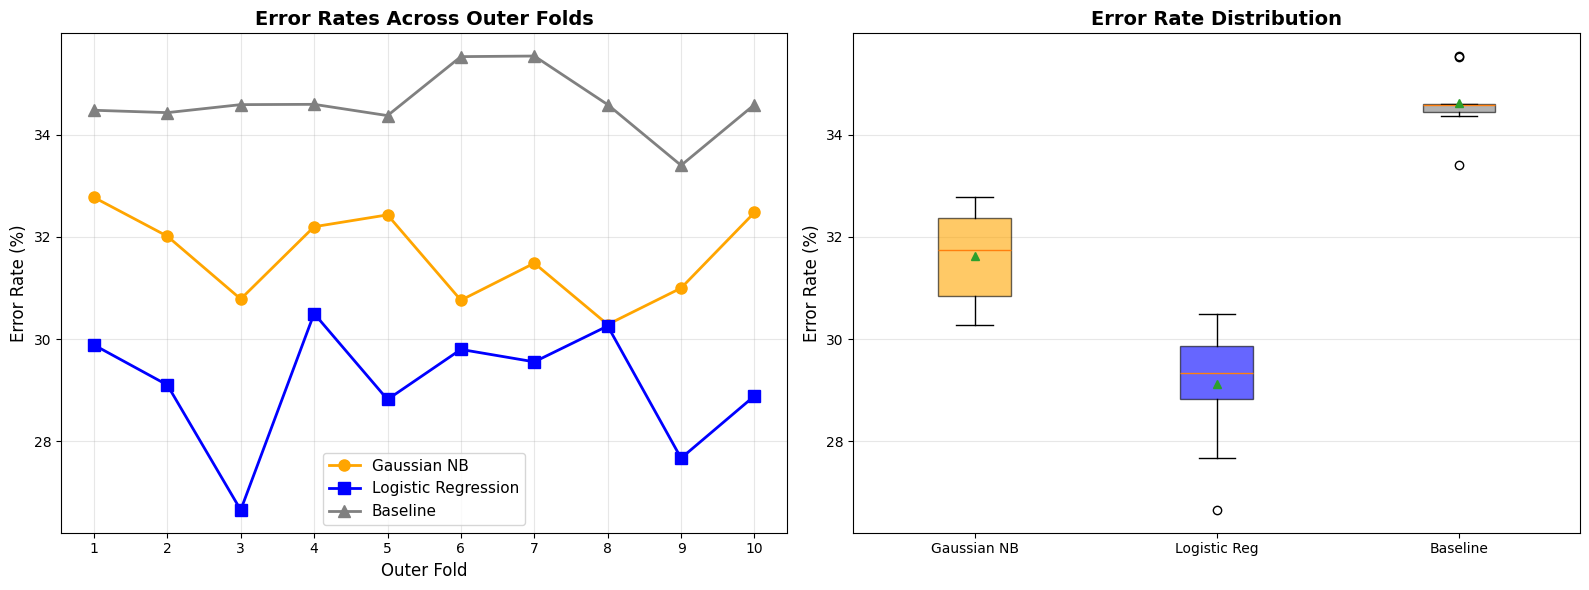

In [139]:
# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error rates across folds
folds = cv_results["outer_fold"]
ax1.plot(
    folds,
    cv_results["nb_error"],
    "o-",
    linewidth=2,
    markersize=8,
    label="Gaussian NB",
    color="orange",
)
ax1.plot(
    folds,
    cv_results["logreg_error"],
    "s-",
    linewidth=2,
    markersize=8,
    label="Logistic Regression",
    color="blue",
)
ax1.plot(
    folds,
    cv_results["baseline_error"],
    "^-",
    linewidth=2,
    markersize=8,
    label="Baseline",
    color="gray",
)
ax1.set_xlabel("Outer Fold", fontsize=12)
ax1.set_ylabel("Error Rate (%)", fontsize=12)
ax1.set_title("Error Rates Across Outer Folds", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(folds)

# Plot 2: Box plot comparison
error_data = [
    cv_results["nb_error"],
    cv_results["logreg_error"],
    cv_results["baseline_error"],
]
bp = ax2.boxplot(
    error_data,
    tick_labels=["Gaussian NB", "Logistic Reg", "Baseline"],
    patch_artist=True,
    showmeans=True,
)
colors = ["orange", "blue", "gray"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_ylabel("Error Rate (%)", fontsize=12)
ax2.set_title("Error Rate Distribution", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Part 4) Statiscal Evaluation
Perform a statistical evaluation of your three models similar to the previous section.

That is, compare the three models pairwise. We will once more allow some freedom in what test to choose. Therefore, choose either:
- Setup I (11.3): Use McNemar’s test described in 11.3.2
- Setup II (11.4): Use the method described in 11.4.1

Include p-values and confidence intervals for the three pairwise tests in your report and conclude on the results:
- Is one model better than the other?
- Are the two models better than the baseline?
- Are some of the models identical?
- What recommendations would you make based on what you’ve learned?

## Part 5) Logistic regression model training

1. Train a logistic regression model using a suitable value of λ (see previous exercise).

2. Explain how the logistic regression model make a prediction.

3. Are the same features deemed relevant as for the regression part of the report?